# Square Matrix Generator
The purpose of this notebook is to write (and clearly comment) a function for finding the root of an inverse variance matrix and verifying it via matrix inversion, as well as timing the methods to see if they're viable for use for a 1000x1000 matrix.

Here's the initial test matrices, as well as tests for ensuring they're symmetric (since they're real, this implies their Hermitian, which will make solving for eigenvectors and eigenvalues easier):

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import time
import matplotlib.pyplot as plt

#setting the size of the arrays for testing, will start small for testing and then will scale up for timing
N = 1000

#sigmas exist on a uniform distribution from [100, 300]

#pure diagonal matrix with equal values
def makeV1(N, sigmarange=[100,300]):
    sigma1 = np.random.random()*(sigmarange[1]-sigmarange[0]) + sigmarange[0]
    V1 = sigma1 * np.identity(N)
    return V1
V1 = makeV1(N)
#checks to ensure symmetry (and hermicity since all real)
print np.allclose(V1,np.ndarray.transpose(V1))

#diagonal matrix with different elements
def makeV2(N, sigmarange=[100,300]):
    sigma2 = np.random.rand(N)*(sigmarange[1]-sigmarange[0]) + sigmarange[0]
    V2 = sigma2 * np.identity(N)
    return V2
V2 = makeV2(N)
print np.allclose(V2,np.ndarray.transpose(V2))




True
True


Let's write the method for finding the matrix square roots. The general idea is that we can decompose a matrix $V$ as:

$V = \sum_d^D \lambda_d \vec{U} \vec{U}^T$
or
$V^{-1} = \sum_d^D \frac{1}{\lambda_d} \vec{U} \vec{U}^T$

Where $\lambda_d$ are the eigenvalues, and $\vec{U}_d$ are the corresponding eigenvectors. This can be further decomposed as:

$V^{-1} = \sum_d^D \frac{1}{\sqrt{\lambda_d}}  \vec{U} \cdot \vec{U}^T \frac{1}{\sqrt{\lambda_d}}$

If we set the definition $w_d \equiv \frac{1}{\sqrt{\lambda_d}} \vec{U}_d ^T$, then we can write:

$V^{-1}= w^{T} \cdot w$

So inverting the matrix becomes a simple case of finding the eigenvectors and eigenvalues, constructing $w$, and transposing and taking the dot product.

My function below calculates $w$:


In [2]:
#computes matrix square root of inverse variance matrix provided variance matrix
def matrixsqrt(V, label="0"):
    N = len(V[0])
    #extracts eigenvalues and eigenvectors (bottleneck!)
    eigs, eigvecs = sp.linalg.eigh(V)
    wt = np.empty([N,N]) #square root matrix (transposed)
    logdet = 0.
    start = time.time()
    for i in range(N):
        #sets each column in our transposed square root to the eigenvalue scaled by 1/sqrt(eig)
        wt[:,i] = (1./np.sqrt(eigs[i])) * eigvecs[:,i]
        logdet += np.log(2 * np.pi * eigs[i])
        #transposes the result
    w = np.ndarray.transpose(wt)
    end = time.time()
    dt = end-start
    if(label!="0"):
        print("Time elapsed for " + label + " is: " + str(dt) + "s")
    return w, logdet, dt


Let's test this with our two test functions. Taking the dot product of the matrix square root and it's transpose should produce $V^{-1}$, so the dot product of that with $V$ should  produce the identity matrix, so this is our test:

In [3]:
w1, logdet1, dt1 = matrixsqrt(V1, label="V1")
print np.dot(V1, np.dot(np.ndarray.transpose(w1), w1))


w2, logdet2, dt2 = matrixsqrt(V2, label="V2")
print np.dot(V2, np.dot(np.ndarray.transpose(w2), w2))


Time elapsed for V1 is: 0.015300989151s
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Time elapsed for V2 is: 0.0181260108948s
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Great, it looks like we're working. Let's try the third sample variance matrix, which is our second test matrix $V_2$ added with a kernal matrix $K$, defined as:

$K_{ab} = A \cdot exp\left({-\frac{1}{2}\frac{(t_a-t_b)^2}{\tau^2}}\right)$

Where $A$ and $\tau$ are parameters to be fit corresponding to noise and time correlation, but for testing purposes, we'll set them to $A=200$ and $\tau = 30s$.

In [4]:
#opening data
data1 = "/users/chris/Documents/QPP/SolarFlareGPs/data/121022782_ctime_lc.txt"
t1, I1 = np.loadtxt(data1, unpack=True)

def makeV3(t, sigmarange=[100,300], A=300, tau=30):
    N = len(t)
    K = np.empty([N,N])
    for i in range(N):
        for j in range(N):
            K[i][j] = A * np.exp(-0.5 * np.power(((t1[i]-t1[j])/(tau)),2))
    V3 = makeV2(N, sigmarange=sigmarange) + K
    return V3
V3 = makeV3(t1)
print np.allclose(V3,np.ndarray.transpose(V3))

True


And now, let's try to find the matrix square root of this guy:

In [5]:
w3, logdet3, dt3 = matrixsqrt(V3, label="V3")
result = np.dot(V3, np.dot(np.ndarray.transpose(w3), w3))
#Didn't print the matrix because it's too big and contains small off-diagonal elements 
print np.allclose(result,np.identity(len(t1)))

Time elapsed for V3 is: 0.0173990726471s
True


To be concise, lets make a convergence plot:

Working...


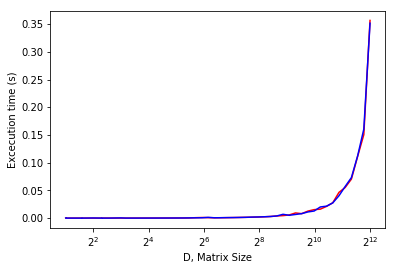

In [8]:
NArray = np.logspace(1, 12, base=2, dtype='int')
dt1 = np.empty(len(NArray))
dt2 = np.empty(len(NArray))
print "Working..."
for i in range(len(NArray)):
    w1, logdet1, dt1[i] = matrixsqrt(makeV1(NArray[i]))
    w2, logdet2, dt2[i] = matrixsqrt(makeV2(NArray[i]))

fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_xlabel("D, Matrix Size")
ax.set_ylabel("Excecution time (s)")
ax.plot(NArray, dt1, 'r-')
ax.plot(NArray, dt2, 'b-')
plt.show()